# RESNET50

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import cv2 as cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, f1_score, classification_report
warnings.filterwarnings('ignore')
tf.keras.backend.clear_session()

## Load Images

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
df["id_code"] = df["id_code"].astype(str) + ".png"
label_map = dict(zip(df["id_code"], df["diagnosis"]))
dataset_path = 'colored_images'
X = []
y = []


In [4]:
df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [5]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):
        print(f"🔄 Loading images from {subfolder}...")

        for filename in tqdm(os.listdir(subfolder_path)):
            img_path = os.path.join(subfolder_path, filename)

          
            if filename in label_map:
                label = label_map[filename] 
                
                # Load gambar
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))  
                    X.append(img)
                    y.append(label) 

print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(y)}")

🔄 Loading images from Mild...


100%|██████████| 370/370 [00:00<00:00, 896.39it/s]


🔄 Loading images from Moderate...


100%|██████████| 999/999 [00:01<00:00, 878.68it/s]


🔄 Loading images from No_DR...


100%|██████████| 1805/1805 [00:02<00:00, 879.64it/s]


🔄 Loading images from Proliferate_DR...


100%|██████████| 295/295 [00:00<00:00, 841.00it/s]


🔄 Loading images from Severe...


100%|██████████| 193/193 [00:00<00:00, 802.09it/s]

Total images loaded: 3662
Total labels loaded: 3662


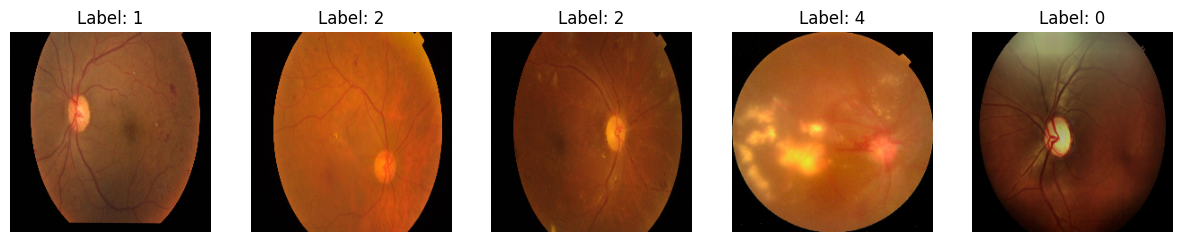

In [6]:
import random

random_indices = random.sample(range(len(X)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[index])
    plt.title(f"Label: {y[index]}")
    plt.axis('off')
plt.show()


In [7]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):  # Cek apakah benar-benar folder
        count = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])
        print(f'Jumlah gambar pada folder {subfolder}: {count}')

Jumlah gambar pada folder Mild: 370
Jumlah gambar pada folder Moderate: 999
Jumlah gambar pada folder No_DR: 1805
Jumlah gambar pada folder Proliferate_DR: 295
Jumlah gambar pada folder Severe: 193


## Splitting Data

In [8]:
X = np.array(X)
y = np.array(y)

X_train, X_remainingdata, y_train, y_remainingdata = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_remainingdata, y_remainingdata, test_size=0.25, random_state=42, stratify=y_remainingdata)

print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data validasi: {len(X_valid)}")
print(f"Ukuran data testing: {len(X_test)}")


Ukuran data training: 2197
Ukuran data validasi: 1098
Ukuran data testing: 367


In [9]:
print(X_train.shape)

(2197, 224, 224, 3)


In [10]:
from collections import Counter
print("\nDistribusi kelas :")
print("Training:", Counter(y_train))
print("Validation:", Counter(y_valid))
print("Testing:", Counter(y_test))


Distribusi kelas :
Training: Counter({0: 1083, 2: 599, 1: 222, 4: 177, 3: 116})
Validation: Counter({0: 541, 2: 300, 1: 111, 4: 88, 3: 58})
Testing: Counter({0: 181, 2: 100, 1: 37, 4: 30, 3: 19})


## Preprocessing Image


In [11]:
def preprocess_image(image):
    # Ekstrak green channel
    green_channel = image[:, :, 1]

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enha = clahe.apply(green_channel)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(enha, (3, 3), sigmaX=0.3, sigmaY=0.3)

    # Konversi kembali ke 3 channel
    processed_image = cv2.merge([blurred, blurred, blurred])

    return processed_image


X_train_processed = np.array([preprocess_image(img) for img in X_train])
X_valid_processed = np.array([preprocess_image(img) for img in X_valid])
X_test_processed = np.array([preprocess_image(img) for img in X_test])

In [12]:
print("Shape X_train_processed:", X_train_processed.shape)
print("Shape X_valid_processed:", X_valid_processed.shape)
print("Shape X_test_processed:", X_test_processed.shape)

Shape X_train_processed: (2197, 224, 224, 3)
Shape X_valid_processed: (1098, 224, 224, 3)
Shape X_test_processed: (367, 224, 224, 3)


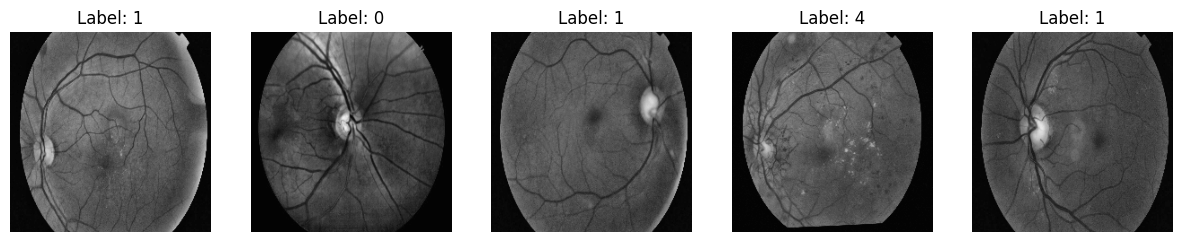

In [13]:
# Displaying sample preprocessed images
random_indices = random.sample(range(len(X_train_processed)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_processed[index])
    plt.title(f"Label: {y_train[index]}")
    plt.axis('off')
plt.show()


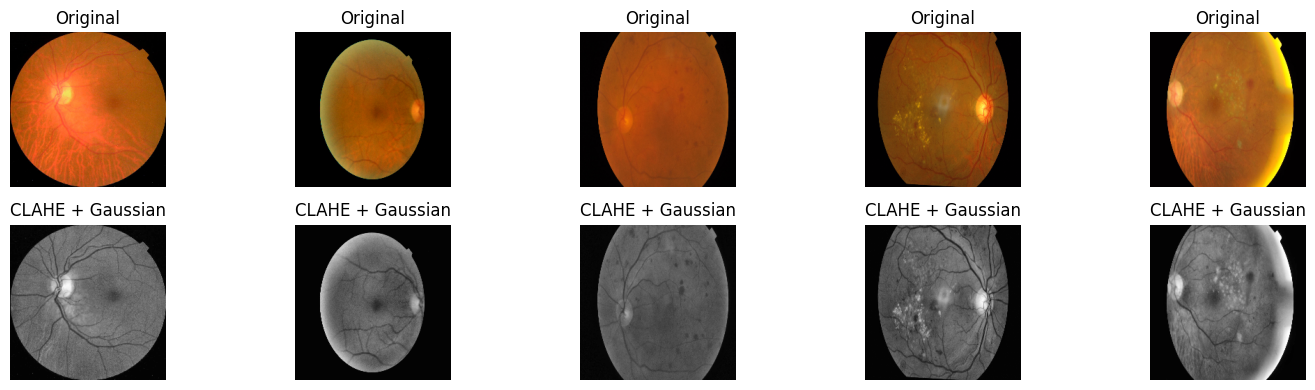

In [14]:
n_samples = 5
sample_indices = np.random.choice(len(X), n_samples, replace=False)
sample_originals = [X[i] for i in sample_indices]
sample_processed = [preprocess_image(img) for img in sample_originals]

# Tampilkan hasil
plt.figure(figsize=(15, 4))
for i in range(n_samples):
    # Gambar original (atas)
    plt.subplot(2, n_samples, i + 1)
    #original_rgb = cv2.cvtColor(sample_originals[i], cv2.COLOR_BGR2RGB)
    plt.imshow(sample_originals[i])
    plt.title("Original")
    plt.axis("off")

    # Gambar hasil preprocess (bawah)
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(sample_processed[i], cmap='gray')  # bisa juga hapus cmap biar full RGB grayscale
    plt.title("CLAHE + Gaussian")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Build Model ResNet50

In [15]:
n_class = 5

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers :
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_class, activation='softmax')(x)

adam = Adam(lr=1e-4)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [16]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=n_class)
y_valid_one_hot = to_categorical(y_valid, num_classes=n_class)
y_test_one_hot = to_categorical(y_test, num_classes=n_class )

In [17]:
print(X_train_processed.shape)
print(y_train_one_hot.shape)
print(X_valid_processed.shape)
print(y_valid_one_hot.shape)

(2197, 224, 224, 3)
(2197, 5)
(1098, 224, 224, 3)
(1098, 5)


In [18]:
es = EarlyStopping(monitor='val_loss', patience=5)
rlr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7)

In [19]:
history = model.fit(X_train_processed,y_train_one_hot, epochs=32, batch_size=8, validation_data=(X_valid_processed, y_valid_one_hot), callbacks=[es, rlr])

Epoch 1/32
275/275 [==============================] - 54s 146ms/step - loss: 0.9675 - accuracy: 0.6586 - recall: 0.5303 - precision: 0.7570 - val_loss: 0.7129 - val_accuracy: 0.7313 - val_recall: 0.6202 - val_precision: 0.8407 - lr: 1.0000e-04
Epoch 2/32
275/275 [==============================] - 55s 202ms/step - loss: 0.7131 - accuracy: 0.7365 - recall: 0.6386 - precision: 0.8148 - val_loss: 0.6491 - val_accuracy: 0.7541 - val_recall: 0.6913 - val_precision: 0.8153 - lr: 1.0000e-04
Epoch 3/32
275/275 [==============================] - 55s 202ms/step - loss: 0.6560 - accuracy: 0.7497 - recall: 0.6714 - precision: 0.8069 - val_loss: 0.6339 - val_accuracy: 0.7559 - val_recall: 0.7122 - val_precision: 0.8070 - lr: 1.0000e-04
Epoch 4/32
275/275 [==============================] - 39s 143ms/step - loss: 0.6098 - accuracy: 0.7724 - recall: 0.7037 - precision: 0.8325 - val_loss: 0.6291 - val_accuracy: 0.7732 - val_recall: 0.6849 - val_precision: 0.8300 - lr: 1.0000e-04
Epoch 5/32
275/275 [====

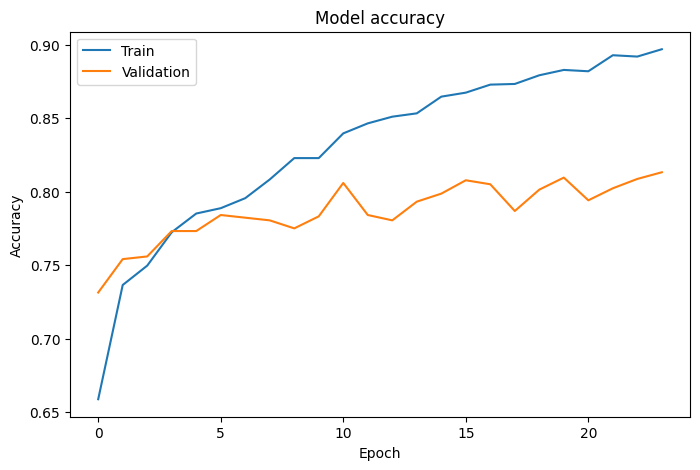

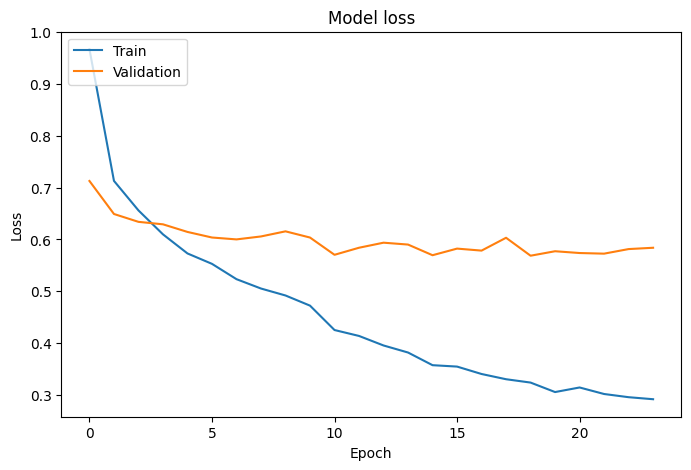

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


69/69 [==============================] - 22s 279ms/step


<Figure size 700x600 with 0 Axes>

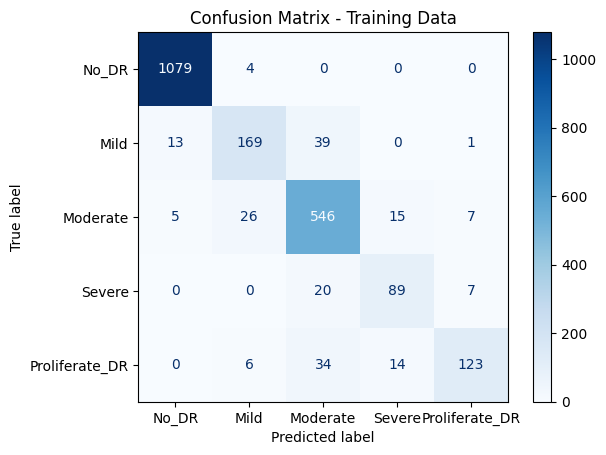

Classification Report (Train):
                precision    recall  f1-score   support

         No_DR       0.98      1.00      0.99      1083
          Mild       0.82      0.76      0.79       222
      Moderate       0.85      0.91      0.88       599
        Severe       0.75      0.77      0.76       116
Proliferate_DR       0.89      0.69      0.78       177

      accuracy                           0.91      2197
     macro avg       0.86      0.83      0.84      2197
  weighted avg       0.91      0.91      0.91      2197



In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_train_true = np.argmax(y_train_one_hot, axis=1)

# Prediksi data training
y_train_pred_probs = model.predict(X_train_processed)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Confusion matrix train
cm_train = confusion_matrix(y_train_true, y_train_pred)
labels = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Plot
plt.figure(figsize=(7,6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_train.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Classification Report
print("Classification Report (Train):")
print(classification_report(y_train_true, y_train_pred, target_names=labels))

## Test Evaluate

In [22]:
print("Shape y_test_one_hot:", y_test_one_hot.shape)
print("Shape x_test_processed:", X_test_processed.shape)


Shape y_test_one_hot: (367, 5)
Shape x_test_processed: (367, 224, 224, 3)


In [23]:
y_true = np.argmax(y_test_one_hot, axis=1) 
y_pred = model.predict(X_test_processed)  
y_pred = np.argmax(y_pred, axis=1)  

12/12 [==============================] - 6s 586ms/step


In [24]:
print(model.evaluate(X_test_processed, y_test_one_hot))

12/12 [==============================] - 4s 337ms/step - loss: 0.6011 - accuracy: 0.8093 - recall: 0.7738 - precision: 0.8402
[0.6010951995849609, 0.8092643022537231, 0.7738419771194458, 0.8402366638183594]


12/12 [==============================] - 9s 792ms/step


<Figure size 700x600 with 0 Axes>

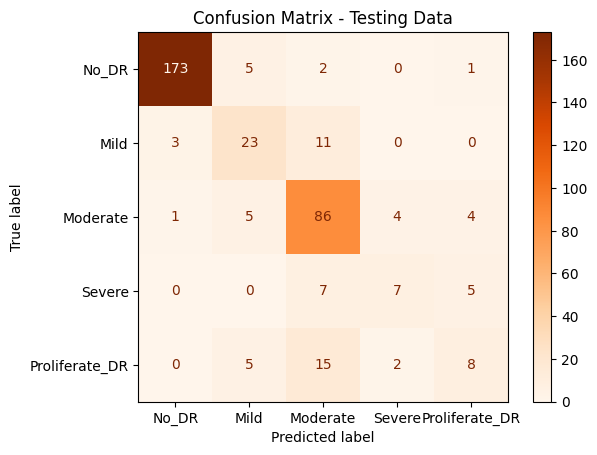

Classification Report (Test):
                precision    recall  f1-score   support

         No_DR       0.98      0.96      0.97       181
          Mild       0.61      0.62      0.61        37
      Moderate       0.71      0.86      0.78       100
        Severe       0.54      0.37      0.44        19
Proliferate_DR       0.44      0.27      0.33        30

      accuracy                           0.81       367
     macro avg       0.66      0.61      0.63       367
  weighted avg       0.80      0.81      0.80       367



In [25]:
# Konversi one-hot label test ke label asli
y_test_true = np.argmax(y_test_one_hot, axis=1)

# Prediksi data test
y_test_pred_probs = model.predict(X_test_processed)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Confusion matrix test
cm_test = confusion_matrix(y_test_true, y_test_pred)

# Plot
plt.figure(figsize=(7,6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_test.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title('Confusion Matrix - Testing Data')
plt.show()

# Classification Report
print("Classification Report (Test):")
print(classification_report(y_test_true, y_test_pred, target_names=labels))


In [26]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f'Macro F1 Score: ', macro_f1)

Macro F1 Score:  0.6257855313160933


In [27]:
from glob import glob
image_paths = glob("test_images/*.png") + glob("test_images/*.jpg")
random.shuffle(image_paths)
image_paths = image_paths[:10]  # Increased sample size for better analysis
print(f"Ditemukan {len(image_paths)} gambar fundus")

Ditemukan 10 gambar fundus


1/1 [==============================] - 0s 22ms/step


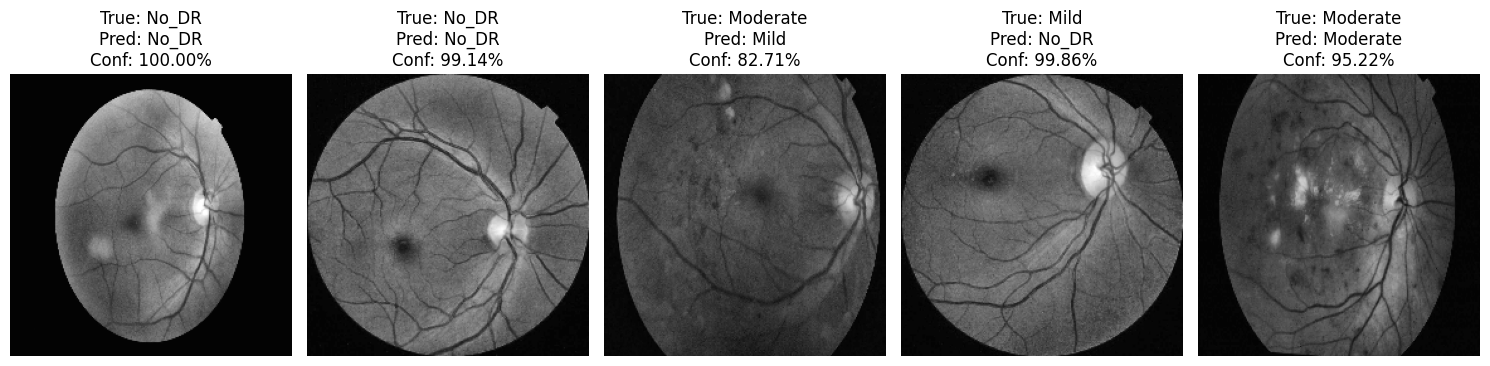

In [28]:
# Pilih beberapa sample acak dari data test
sample_indices = random.sample(range(len(X_test_processed)), 5)
sample_images = X_test_processed[sample_indices]
sample_true_labels = y_test_true[sample_indices]
sample_pred_probs = model.predict(sample_images)
sample_pred_labels = np.argmax(sample_pred_probs, axis=1)
sample_confidences = np.max(sample_pred_probs, axis=1)

# Visualisasi hasil prediksi
plt.figure(figsize=(15, 5))
for i in range(5):
    img = sample_images[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {labels[sample_true_labels[i]]}\nPred: {labels[sample_pred_labels[i]]}\nConf: {sample_confidences[i]:.2%}")
    plt.axis("off")

plt.tight_layout()
plt.show()
